# Introduction

I will go over my implementation of the original YOLO model for object detection ([Redmon et al. 2016](https://arxiv.org/abs/1506.02640)). There are couple of implementation details that are hard to get directly from the paper. If you also are struggling with them I think you will find this notebook helpful.

I won't be explaining the theory behind YOLO here. There are some videos on YouTube doing that, but to be honest I didn't find them that helpful. I think the best way to understand it is through coding.

Sources I found helpful:
* https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/object_detection/YOLO
* https://github.com/tanjeffreyz/yolo-v1


# Dependencies

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import Module, Conv2d, Flatten, Unflatten, Linear, Sequential, LeakyReLU, Dropout

import torch.optim as optim

import torchvision.transforms as transforms
from torchvision.datasets import VOCDetection
from torch.utils.data import DataLoader

from torchvision.models import EfficientNet_V2_S_Weights, efficientnet_v2_s, resnet34, ResNet34_Weights

import copy
from tqdm import tqdm

The code below makes the notebook device agnostic. It will detect if it can use GPU or not.

I'm working on GPU T4 in Google Colab.

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Data

Same as in the paper, I will use the PASCAL VOC 2007 dataset for training. It consists of images along with annotations specifying which objects are present in each image and their locations. Let's see an example.

In [ ]:
voc_dataset = VOCDetection(
    root="./data", # where to store the dataset
    year="2007",
    image_set="trainval",  # Options: 'train', 'val', 'trainval', 'test'
    transform=transforms.ToTensor(), # load the images as pytorch tensors
    download=True
)

100%|██████████| 460M/460M [00:16<00:00, 27.5MB/s]


In [ ]:
img, target = voc_dataset[0]
target

{'annotation': {'folder': 'VOC2007',
  'filename': '000005.jpg',
  'source': {'database': 'The VOC2007 Database',
   'annotation': 'PASCAL VOC2007',
   'image': 'flickr',
   'flickrid': '325991873'},
  'owner': {'flickrid': 'archintent louisville', 'name': '?'},
  'size': {'width': '500', 'height': '375', 'depth': '3'},
  'segmented': '0',
  'object': [{'name': 'chair',
    'pose': 'Rear',
    'truncated': '0',
    'difficult': '0',
    'bndbox': {'xmin': '263', 'ymin': '211', 'xmax': '324', 'ymax': '339'}},
   {'name': 'chair',
    'pose': 'Unspecified',
    'truncated': '0',
    'difficult': '0',
    'bndbox': {'xmin': '165', 'ymin': '264', 'xmax': '253', 'ymax': '372'}},
   {'name': 'chair',
    'pose': 'Unspecified',
    'truncated': '1',
    'difficult': '1',
    'bndbox': {'xmin': '5', 'ymin': '244', 'xmax': '67', 'ymax': '374'}},
   {'name': 'chair',
    'pose': 'Unspecified',
    'truncated': '0',
    'difficult': '0',
    'bndbox': {'xmin': '241', 'ymin': '194', 'xmax': '295',

There is a lot of information in the target, however I will only need image size and information about objects in the image.

In [ ]:
def extract_info(target):
    info = {}
    info["size"] = {"width": int(target["annotation"]["size"]["width"]),
                    "height": int(target["annotation"]["size"]["height"])}
    info["objects"] = []
    for ob in target["annotation"]["object"]:
        info["objects"].append({
            "name": ob["name"],
            "xmin": int(ob["bndbox"]["xmin"]),
            "xmax": int(ob["bndbox"]["xmax"]),
            "ymin": int(ob["bndbox"]["ymin"]),
            "ymax": int(ob["bndbox"]["ymax"])
        })
    return info

In [ ]:
target = extract_info(target)
target

{'size': {'width': 500, 'height': 375},
 'objects': [{'name': 'chair',
   'xmin': 263,
   'xmax': 324,
   'ymin': 211,
   'ymax': 339},
  {'name': 'chair', 'xmin': 165, 'xmax': 253, 'ymin': 264, 'ymax': 372},
  {'name': 'chair', 'xmin': 5, 'xmax': 67, 'ymin': 244, 'ymax': 374},
  {'name': 'chair', 'xmin': 241, 'xmax': 295, 'ymin': 194, 'ymax': 299},
  {'name': 'chair', 'xmin': 277, 'xmax': 312, 'ymin': 186, 'ymax': 220}]}

Now let's plot the image.

In [ ]:
def plot_image(image, info):
    plt.imshow(image.permute(1,2,0))
    colors = plt.get_cmap("tab10", len(info["objects"]))
    i = 0
    for ob in info['objects']:
        xmin,xmax = int(ob['xmin']),int(ob['xmax'])
        ymin,ymax = int(ob['ymin']),int(ob['ymax'])
        plt.plot([xmin, xmax], [ymin, ymin], c=colors(i))
        plt.plot([xmin, xmax], [ymax, ymax], c=colors(i))
        plt.vlines(xmin, ymin, ymax, color=colors(i))
        plt.vlines(xmax, ymin, ymax, color=colors(i))
        plt.text(xmin, ymin-1, ob["name"], fontsize=10, color=colors(i), weight="bold")
        i+=1
    plt.show()

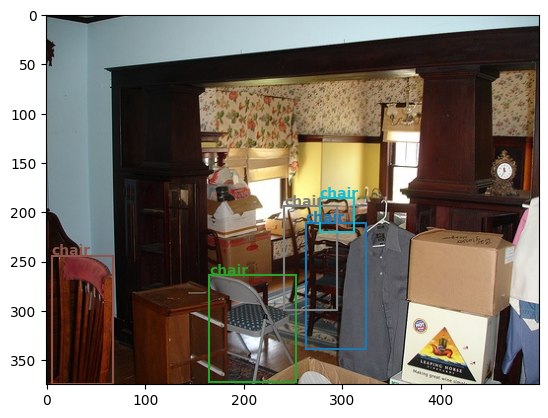

In [ ]:
plot_image(img, target)

The original YOLO model was trained on 448x448 images. Images in PASCAL VOC 2007 come in various sizes, so I have to resize them. That's easy, just add torch.transforms.Resize(448,448) to the transform argument when loading dataset. However, I also need to resize the bounding boxes.

In [ ]:
def resize_bndbox(target):
    resized_target = copy.deepcopy(target)
    for ob in resized_target["objects"]:
        ob["xmin"] = int(ob["xmin"] / target["size"]["width"] * 448)
        ob["xmax"] = int(ob["xmax"] / target["size"]["width"] * 448)
        ob["ymin"] = int(ob["ymin"] / target["size"]["height"] * 448)
        ob["ymax"] = int(ob["ymax"] / target["size"]["height"] * 448)

    resized_target["size"]["width"] = 448
    resized_target["size"]["height"] = 448

    return resized_target

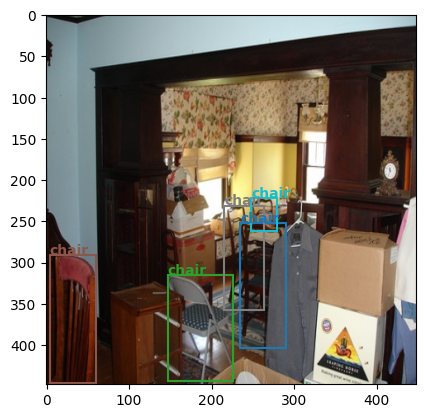

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((448,448))])
voc_dataset = VOCDetection(
    root="./data", # where to store the dataset
    year="2007",
    image_set="trainval",  # Options: 'train', 'val', 'trainval', 'test'
    transform=transform, # load the images as pytorch tensors
    download=True
)

img, target = voc_dataset[0]
target = extract_info(target)
target = resize_bndbox(target)

plot_image(img, target)

It looks fine.

Now I will wrap up this and more in a custom class that inherits from the VOCDetection class. When I do voc_dataset[0] I actually call the \_\_getitem\_\_ function defined in VOCDetection. I will overwrite it so that it returns images and targets in a different format. Besides extracting required information and rescaling the boxes I would also like to store it in the same shape as the outputs of the YOLO model which are SxSx(C+B\*5) tensors.

The image should be divided by a SxS grid into S^2 cells. Each cell should contain information about what type of object it stores, if any, and about the bounding box around it. Let A be our target tensor, then:

* A[i,j,0:C] - is a one-hot encoding of the object class that is present in the (i,j) cell. The YOLO model returns the class probabilities, but we are working with the real values right now, not the predictions.
* A[i,j,C] - is the x coordinate of the center of the bounding box. It is relative to the edges of the (i,j) grid cell and it's divided by the grid cell's width so that it falls into (0,1) range.
* A[i,j,C+1] - same as above but for the y coordinate.
* A[i,j,C+2] - width of the bounding box divided by 448 (width of the image).
* A[i,j,C+3] - same but for height.
* A[i,j,C+4] - confidence of the model, but because we are working with the real data right now we set it to 1.

The rest of the values (A[i,j,C+5:]) are the last five values repeated B times. These could also be zeros, but because of how I implemented my Intersection over Union (IoU) function later I will leave it this way.

The original YOLO model can't spot two objects in one grid cell. If there is in fact more then one object in one grid cell, I will encode only the first one.

In [ ]:
class YOLOVOCDataset(VOCDetection):
    def __init__(self, root, year, image_set, transform=None, S=7, B=2, C=20):
        super().__init__(root=root, year=year, image_set=image_set, download=True, transform=transform)
        self.class_map = {}
        self.S = S
        self.B = B
        self.C = C

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        target_tensor = self.process_target(target)
        return img, target_tensor

    def process_target(self, target):
        info = extract_info(target)
        info = resize_bndbox(info)
        target_tensor = torch.zeros((self.S, self.S, 5*self.B + self.C))
        nonempty_cells = set() # only one object per cell

        cell_width = 448 / self.S
        cell_height = 448 / self.S

        for ob in info["objects"]:
            x = (ob["xmin"] + ob["xmax"]) / 2 # center of the box
            col = int(x // cell_width) # column in the grid
            x = x % cell_width / cell_width # it has to be relative to the grid cell
            y = (ob["ymin"] + ob["ymax"]) / 2
            row = int(y // cell_height)
            y = y % cell_height / cell_height

            # encoding only one object in one grid cell
            if (row, col) in nonempty_cells:
                continue
            nonempty_cells.add((row,col))

            # dimensions of the box
            w = (ob["xmax"] - ob['xmin']) / 448
            h = (ob["ymax"] - ob['ymin']) / 448
            # confidence
            c = 1.0

            target_tensor[row, col, self.C:] = torch.tensor([x,y,w,h,c] * self.B)

            # encoding class
            target_tensor[row,col,self._get_class_id(ob["name"])] = 1.0

        return target_tensor

    def _get_class_id(self, class_name):
        """Returns id of the class (index in one-hot encoding).
        Creates new id if the class was not seen before"""
        if class_name not in self.class_map:
            next_id = len(self.class_map)
            self.class_map[class_name] = next_id

        return self.class_map[class_name]

# Model

The original YOLO model has 24 convolutional layers followed by 2 fully connected layers. Convolutional layers are first trained on ImageNet and then the model is converted to perform detection. Instead of training my own convolutional layers I will be using a pretrained *resnet34* from *torchvision.models*. This will save me a lot of time.

In [ ]:
class YOLO(Module):
    def __init__(self, S=7, B=2, C=20):
        super().__init__()
        self.S = S
        self.B = B
        self.C = C
        # last two layers are AvgPool and classification head for ImageNet so I drop them
        resnet = resnet34(weights=ResNet34_Weights.DEFAULT)
        self.backbone = Sequential(*list(resnet.children())[:-2])
        # resnet outputs (512,14,14) tensors
        self.backbone.requires_grad_(False)
        self.head = Sequential(
            Conv2d(512, 1024, kernel_size=3, padding=1),
            LeakyReLU(negative_slope=0.1),

            Conv2d(1024, 1024, kernel_size=3, stride=2, padding=1), # this will resize to (7,7)
            LeakyReLU(negative_slope=0.1),

            Conv2d(1024, 1024, kernel_size=3, padding=1),
            LeakyReLU(negative_slope=0.1),

            Conv2d(1024, 1024, kernel_size=3, padding=1),
            LeakyReLU(negative_slope=0.1),

            Flatten(),
            Linear(self.S * self.S * 1024, 4096),
            #Dropout(),
            LeakyReLU(0.1),
            Linear(4096, self.S * self.S * (self.B*5+self.C)),
            Unflatten(dim=1, unflattened_size=(self.S, self.S, self.B*5+self.C))
        )

    def forward(self, x):
        return self.head(self.backbone(x))

Altough resnet wasn't trained on 448x448 images it will still work because of the nature of the convolutional layers.

Now, the most essential part - calculating the loss function.

In [ ]:
def loss_fun(preds, target, C=20, l_coord=5, l_noobj=0.5):
    obj_mask = target[:,:,:,-1] > 0 # indicates wheter there is an object in the cell
    # I will be using only the predicted bbox with the highest IoU with the ground truth
    iou = IoU(preds, target)
    responsible_box = torch.argmax(iou, dim=3)
    # I'm interested in all 5 parameters of the bbox and that's why I'm stacking
    # 5 copies of responsible_box below. That's just how torch.gather works.
    responsible_box = torch.stack([responsible_box*5+i+C for i in range(5)], dim=-1)
    responsible_preds = torch.gather(preds, -1, responsible_box) # (batch_size, 7, 7, 5)
    loss_xy = l_coord * \
        torch.sum((responsible_preds[obj_mask][:,:2] - target[obj_mask][:,C:C+2])**2)
    # The model can return negative w and h. I have to make them positive before
    # calculating the square root and then go back to the original sign. I also add
    # 1e-6 for numerical stability.
    loss_wh = l_coord * \
        torch.sum(
            (torch.sqrt(torch.abs(responsible_preds[obj_mask][:,2:4])+1e-6)*
            torch.sign(responsible_preds[obj_mask][:,2:4]) -
            torch.sqrt(target[obj_mask][:,C+2:C+4]))**2)
    loss_c = \
        torch.sum((responsible_preds[obj_mask][:,4] - target[obj_mask][:,C+4])**2) + \
        l_noobj * \
        torch.sum((responsible_preds[~obj_mask][:,4] - target[~obj_mask][:,C+4])**2)
    loss_p = \
        torch.sum((preds[obj_mask][:,:C] - target[obj_mask][:,:C])**2)

    loss = (loss_xy + loss_wh + loss_c + loss_p) / target.shape[0]
    return loss

def IoU(bbox1, bbox2, C=20):
    # from x,y,w,h to xmin,xmax,ymin,ymax
    xmax1 = bbox1[:,:,:,C::5] + bbox1[:,:,:,C+2::5] / 2 # (batch, S, S, B)
    xmax2 = bbox2[:,:,:,C::5] + bbox2[:,:,:,C+2::5] / 2
    xmin1 = bbox1[:,:,:,C::5] - bbox1[:,:,:,C+2::5] / 2
    xmin2 = bbox2[:,:,:,C::5] - bbox2[:,:,:,C+2::5] / 2
    ymax1 = bbox1[:,:,:,C+1::5] + bbox1[:,:,:,C+3::5] / 2
    ymax2 = bbox2[:,:,:,C+1::5] + bbox2[:,:,:,C+3::5] / 2
    ymin1 = bbox1[:,:,:,C+1::5] - bbox1[:,:,:,C+3::5] / 2
    ymin2 = bbox2[:,:,:,C+1::5] - bbox2[:,:,:,C+3::5] / 2

    xmax = torch.min(xmax1, xmax2)
    xmin = torch.max(xmin1, xmin2)
    ymax = torch.min(ymax1, ymax2)
    ymin = torch.max(ymin1, ymin2)

    intersection = torch.clip(ymax-ymin, min=0) * torch.clip(xmax-xmin, min=0)
    union = (xmax1-xmin1) * (ymax1-ymin1) + (xmax2-xmin2) * (ymax2-ymin2) - intersection
    return intersection / (union+1e-6) # (batch,S,S,B)


YOLO outputs B bounding boxes for each cell. That amounts to 98 bounding boxes for B=2 and S=7. However, we don't want to use all of them. First, we drop all bounding boxes with the confidence score below a certain threshold, usually 0.5.

I've seen two different implementations of this. One simply uses the confidence value returned by the model, which indicates how confident the model is that there is an object in the bounding box. The other additionally multiplies this confidence score by the highest predicted class probability. This approach ensures that we consider not only the confidence in detecting any object but also the confidence in detecting the correct class. I decided to go with the second option.

Now, we are left with only the bounding boxes that have high enough confidence. However, multiple bounding boxes might detect the same object. In such cases, we keep only the one with the highest confidence. To determine whether two bounding boxes detect the same object, we check if they predict the same class and then calculate their IoU. If the IoU is higher than a certain threshold, it is likely that both boxes detect the same object. This procedure is called non-maximum suppression.

In [ ]:
def non_max_suppression(pred, iou_threshold=0.5, conf_threshold=0.5, B=2, C=20, S=7):
    # store the information about row and column indexes because it will be
    # necessary for getting the absolute values of bbox coordinates
    rows = torch.arange(S).view(S, 1).expand(S, S)
    cols = torch.arange(S).view(1, S).expand(S, S)
    indexes = torch.stack((rows, cols), dim=-1)
    pred = torch.cat((indexes, pred), dim=-1)

    # for each grid cell, pick the box with higher object confidence
    responsible_box = torch.argmax(pred[:,:,[2+C+4+5*i for i in range(B)]], dim=2)
    # stack 5 copies of responsible_box becuase we need all 5 bbox parameters
    # it's not very intuitive but this is how torch.gather works
    responsible_box = torch.stack([responsible_box*5+i+C+2 for i in range(5)], dim=-1)
    responsible_pred = torch.gather(pred, -1, responsible_box)
    # add probabilites and indexes back
    responsible_pred = torch.cat((pred[:,:,:C+2], responsible_pred), dim=-1)

    # leave only the ones with big enough class confidence
    boxes = responsible_pred[(torch.max(pred[:,:,2:C+2], dim=-1).values*responsible_pred[:,:,-1])>conf_threshold].tolist()

    # classes = torch.cat((indices, pred[:,:,:C]), dim=-1)[responsible_pred[:,:,-1]>conf_threshold]
    # classes = torch.cat((classes[:,:2], torch.argmax(classes[:,2:], dim=-1, keepdim=True)), dim=-1).tolist()
    # boxes = [classes[i]+boxes[i] for i in range(len(classes))]

    # remove boxes that detect the same object
    boxes = sorted(boxes, key=lambda x: x[-1]*max(x[2:C+2]), reverse=True)
    max_boxes = []
    while boxes:
        max_box = boxes.pop(0)
        max_boxes.append(max_box)

        boxes_tmp = []
        for i in range(len(boxes)):
            if max(boxes[i][2:C+2]) != max(max_box[2:C+2]):
                boxes_tmp.append(boxes[i])
            else:
                iou = IoU(torch.tensor(boxes[i][C+2:]).reshape((1,1,1,-1)), torch.tensor(max_box[C+2:]).reshape((1,1,1,-1)), C=0) # why C=0 see IoU implementation
                if iou < iou_threshold:
                    boxes_tmp.append(boxes[i])
        boxes = boxes_tmp
    return max_boxes

# Training
I don't really care about optaining a good object detector for the dataset, as that would take a lot of time. However, I want to somehow check if my implementation works. That's why I will train the model on a single batch and see if I can overfit. This is a good technique if you want to test if there are some errors in your code and if your model is capable of learning at all.

In [ ]:
def train_step(model, data, optimizer, device=DEVICE):
    model.train()
    total_loss = 0.0
    for x, y in data:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fun(pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(data)


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((448,448)),
    # could add normalization, but it works just fine without it
])
voc_dataset = YOLOVOCDataset(
    root="./data",
    year="2007",
    image_set="trainval",
    transform=transform
)

In [ ]:
voc_dataloader = DataLoader(voc_dataset, batch_size=32, shuffle=False)
inputs, targets = next(iter(voc_dataloader)) # only one batch

In [ ]:
model = YOLO().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-5) # don't make lr too big

In [ ]:
EPOCHS = 200
loss_history = []
for epoch in tqdm(range(EPOCHS)):
    loss = train_step(model, [(inputs, targets)], optimizer)
    loss_history.append(loss)

100%|██████████| 200/200 [01:11<00:00,  2.80it/s]


Let's see how the training went.

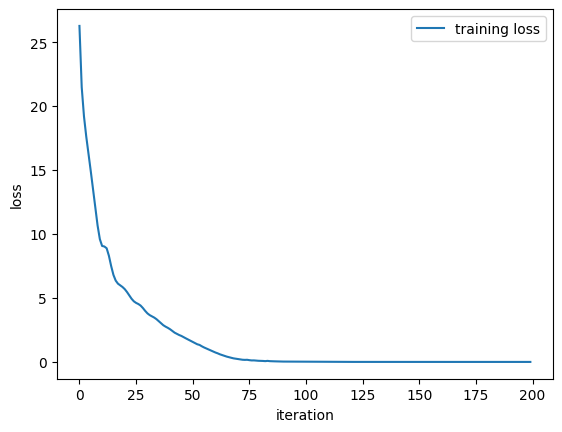

In [ ]:
plt.plot(loss_history, label="training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

In [ ]:
print(f"Final loss = {loss_history[-1]}")

Final loss = 5.375139267016493e-07


It looks very promising, but a small loss value doesn't necessarily mean that the model is doing what we intended. A good way to verify this would be to calculate the mean average precision (mAP). However, instead of that, I will manually go through a few examples to better visualize how the model performs.

In [ ]:
# get couple of examples
imgs = []
targets = []
for i in range(5):
    img,target = voc_dataset[i]
    imgs.append(img)
    targets.append(target)

# get predictions
preds = []
model.eval()
with torch.no_grad():
    for i in range(len(imgs)):
        pred = model(imgs[i].reshape(1,3,448,448).to(DEVICE)).squeeze(0)
        preds.append(pred)

# non-max suppression
predicted_bboxes = []
true_bboxes = []
for i in range(len(imgs)):
    predicted_bbox = non_max_suppression(preds[i].to("cpu"), iou_threshold=0.3, conf_threshold=0.5, B=2, C=20, S=7)
    true_bbox = non_max_suppression(targets[i], iou_threshold=0.3, conf_threshold=0.5, B=2, C=20, S=7)
    predicted_bboxes.append(predicted_bbox)
    true_bboxes.append(true_bbox)
# get class names
class2label = voc_dataset.class_map
label2class = {v: k for k, v in class2label.items()}

In [ ]:
def compare_bboxes(imgs, true_bboxes, predicted_bboxes, label2class, C=20):
    fig, ax =  plt.subplots(len(imgs), 2, figsize=(6, 3 * len(imgs)))
    for i in range(len(imgs)):
        ax[i,0].imshow(imgs[i].permute(1,2,0))
        ax[i,1].imshow(imgs[i].permute(1,2,0))

        colors = plt.get_cmap("tab10", len(true_bboxes[i]))
        for j in range(len(true_bboxes[i])):
            x,y,w,h = rel2abs(*(true_bboxes[i][j][:2]+true_bboxes[i][j][C+2:-1]))
            xmin,xmax,ymin,ymax = mid2cor(x,y,w,h)
            ax[i,0].plot([xmin, xmax], [ymin, ymin], c=colors(j))
            ax[i,0].plot([xmin, xmax], [ymax, ymax], c=colors(j))
            ax[i,0].vlines(xmin, ymin, ymax, color=colors(j))
            ax[i,0].vlines(xmax, ymin, ymax, color=colors(j))
            class_id = torch.argmax(torch.tensor(true_bboxes[i][j][2:C+2]), dim=0).item()
            class_name = label2class[class_id]
            ax[i,0].text(xmin, ymin-1, class_name, fontsize=10, color=colors(j), weight="bold")
            ax[i,0].set_title("True bounding boxes", fontsize=11)
            ax[i, 0].axis("off")

        colors = plt.get_cmap("tab10", len(predicted_bboxes[i]))
        for j in range(len(predicted_bboxes[i])):
            x,y,w,h = rel2abs(*(predicted_bboxes[i][j][:2]+predicted_bboxes[i][j][C+2:-1]))
            xmin,xmax,ymin,ymax = mid2cor(x,y,w,h)
            ax[i,1].plot([xmin, xmax], [ymin, ymin], c=colors(j))
            ax[i,1].plot([xmin, xmax], [ymax, ymax], c=colors(j))
            ax[i,1].vlines(xmin, ymin, ymax, color=colors(j))
            ax[i,1].vlines(xmax, ymin, ymax, color=colors(j))
            class_id = torch.argmax(torch.tensor(predicted_bboxes[i][j][2:C+2])).item()
            class_name = label2class[class_id]
            ax[i,1].text(xmin, ymin-1, class_name, fontsize=10, color=colors(j), weight="bold")
            ax[i,1].set_title("Predicted bounding boxes", fontsize=11)
            ax[i, 1].axis("off")

def rel2abs(row, col, x, y, w, h, S=7):
    """Goes back to absolute values of the bbox"""
    cell_width = 448 / S
    cell_height = 448 / S
    x = x * cell_width + col * cell_width
    y = y * cell_height + row * cell_height
    w *= 448
    h *= 448
    return x, y, w, h
def mid2cor(x,y,w,h):
    """From x,y,w,h to xmin,xmax,ymin,ymax"""
    xmax = x + w / 2
    xmin = x - w / 2
    ymax = y + h / 2
    ymin = y - h / 2
    return xmin, xmax, ymin, ymax

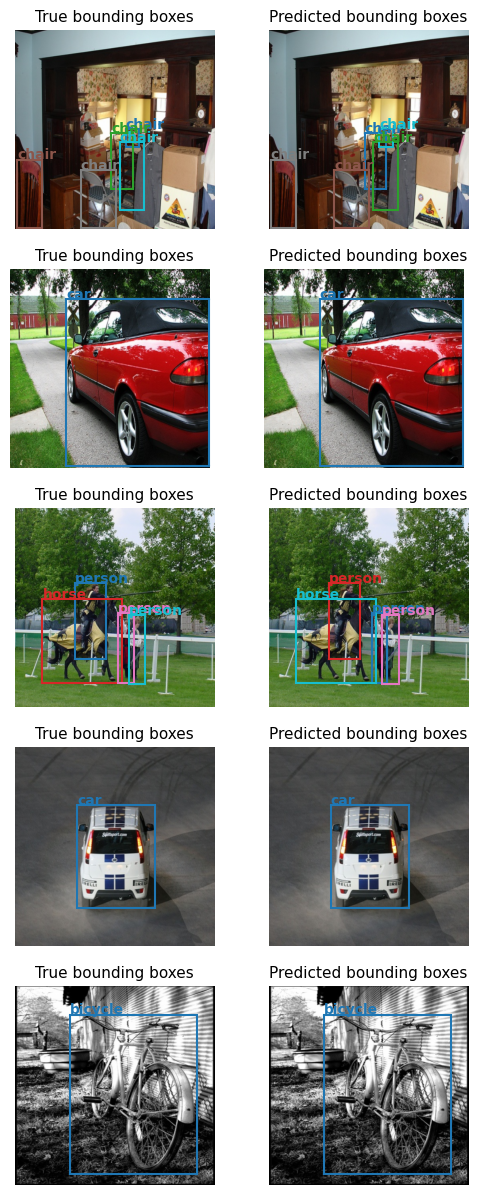

In [ ]:
compare_bboxes(imgs, true_bboxes, predicted_bboxes, label2class)

Model returns basically the same bounding boxes as the orignal ones. Success!!!